In [53]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

print("TensorFlow version: {}".format(tf.__version__)) 

TensorFlow version: 2.4.0


In [54]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "https://raw.githubusercontent.com/PacktWorkshops/The-Reinforcement-Learning-Workshop/master/Chapter03/Dataset/auto-mpg.data")

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [55]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [56]:
dataset = dataset.dropna()

In [57]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [58]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

KeyboardInterrupt: 

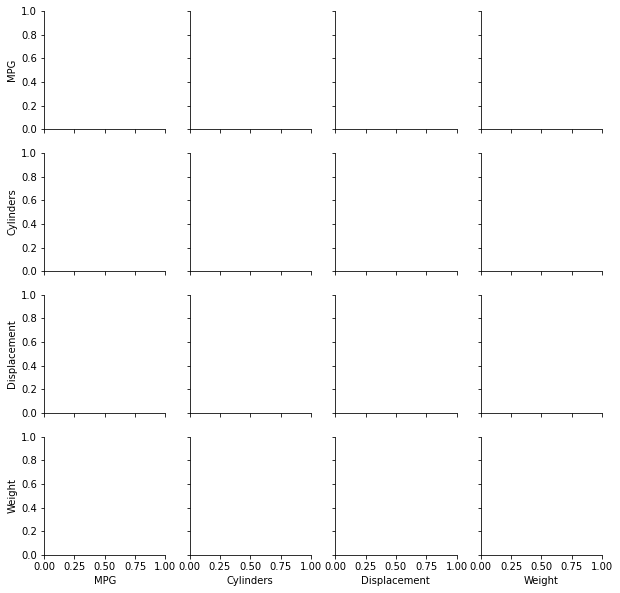

In [59]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

model = build_model()

model.summary()

In [ ]:
epochs = 1000

history = model.fit(normed_train_data, train_labels,
  epochs=epochs, validation_split = 0.2, verbose=2)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(hist['epoch'],hist['mae'])
plt.plot(hist['epoch'],hist['val_mae'])
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
plt.legend(["Training", "Validation"])

In [ ]:
plt.plot(hist['epoch'],hist['mse'])
plt.plot(hist['epoch'],hist['val_mse'])
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')
plt.legend(["Training", "Validation"])

In [ ]:
model = build_model()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=epochs, validation_split = 0.2, verbose=2, 
                    callbacks=[early_stop])

In [ ]:
early_hist = pd.DataFrame(early_history.history)
early_hist['epoch'] = early_history.epoch

plt.plot(early_hist['epoch'],early_hist['mae'])
plt.plot(early_hist['epoch'],early_hist['val_mae'])
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
plt.legend(["Training", "Validation"])

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
